<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°08

**Objetivo**: Aplicar técnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables numéricas y categóricas.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila información sobre diversas características relevantes de distintos vehículos. El propósito de este ejercicio es **clasificar los vehículos en diferentes categorías**, utilizando como base las variables descritas en la tabla de atributos.

El análisis presenta un desafío adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **numéricas** (ej. dimensiones, consumo, emisiones) como **categóricas** (ej. tipo de tracción, tipo de combustible), lo que requiere aplicar técnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las características que servirán como base para la posterior clasificación.




**Descripción de los Datos:**

| **Nombre de la Columna**   | **Descripción**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El año en que el vehículo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volumétrica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revolución.       |
| **cilindros**               | El número de cilindros que tiene el motor. Los cilindros son las cámaras donde ocurre la combustión interna en los motores de los vehículos.       |
| **co2**                     | Emisiones de dióxido de carbono del vehículo, medido en gramos por kilómetro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de vehículo, como vehículos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracción del vehículo, ya sea tracción en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisión del vehículo, como automática, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el vehículo, como gasolina, diésel, eléctrico, híbrido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificación del tamaño del motor (por ejemplo, pequeño, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificación del nivel de consumo de combustible del vehículo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificación de las emisiones de CO2 del vehículo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del vehículo, medido en litros por milla. Indica la eficiencia del vehículo en términos de consumo de combustible.        |



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [ ]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

,year,desplazamiento,cilindros,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,1984,2.5,4.0,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,1984,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,1985,2.5,4.0,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,1985,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,1987,3.8,6.0,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


En este caso, no solo se tienen datos numéricos, sino que también categóricos. Además, tenemos problemas de datos **vacíos (Nan)**. Así que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables numéricas, además, para cada dato vacía, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categóricas , además, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificación de variables numéricas a categóricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

In [ ]:
# Separar variables numéricas y categóricas
df_numeric = df.select_dtypes(include=np.number).copy()
df_categorical = df.select_dtypes(include='object').copy()

# Normalizar datos numéricos
# Rellenar datos vacíos con el promedio
df_numeric = df_numeric.fillna(df_numeric.mean())

# Normalizar con MinMaxScaler
scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)

# Codificar variables categóricas con get_dummies
df_categorical_encoded = pd.get_dummies(df_categorical)

# Explicación de get_dummies:
# get_dummies convierte variables categóricas en variables dummy/indicadoras.
# Para cada columna categórica, crea nuevas columnas binarias (0 o 1)
# por cada categoría única en esa columna. Si una observación tiene una categoría,
# la columna correspondiente a esa categoría tendrá un 1, y las otras columnas
# creadas a partir de la misma variable categórica tendrán un 0.

# Unir ambos dataframes procesados
df_procesado = pd.concat([df_numeric_scaled, df_categorical_encoded], axis=1)

display(df_procesado.head())

,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.000000,0.243590,0.142857,0.398014,0.331027,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,0.000000,0.461538,0.285714,0.527672,0.475113,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0.029412,0.243590,0.142857,0.424351,0.360294,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
3,0.029412,0.461538,0.285714,0.527672,0.475113,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,0.088235,0.410256,0.285714,0.424351,0.360294,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,False


### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables numérica
    * Moda para las variables numericas

In [ ]:
# Ajustar el modelo kmeans con 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
kmeans.fit(df_procesado)

# Asociar a cada individuo el correspondiente cluster
df_procesado['cluster'] = kmeans.labels_

# Calcular centroides
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_procesado.columns[:-1])

# Resumen de las principales cualidades de cada cluster
# Valor promedio de las variables numérica
numeric_cols = df_numeric_scaled.columns
cluster_summary_mean = df_procesado.groupby('cluster')[numeric_cols].mean()

# Moda para las variables numericas
# For mode, we can't directly calculate for scaled data and categorical data.
# We'll calculate mode for original numerical columns and the encoded categorical columns.
# For categorical columns, the mode of the one-hot encoded columns within a cluster
# will indicate the most frequent category in that cluster.

# Calculate mode for original numeric columns
cluster_summary_mode_numeric = df.groupby(df_procesado['cluster'])[df_numeric.columns].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)

# Calculate mode for encoded categorical columns
cluster_summary_mode_categorical = df_procesado.groupby('cluster')[df_categorical_encoded.columns].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)


print("Centroides de los clusters:")
display(centroids)

print("\nValor promedio de las variables numéricas por cluster:")
display(cluster_summary_mean)

print("\nModa de las variables numéricas por cluster:")
display(cluster_summary_mode_numeric)

print("\nModa de las variables categóricas (codificadas) por cluster:")
display(cluster_summary_mode_categorical)

Centroides de los clusters:


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.427318,0.223790,0.173637,0.304599,0.226412,0.126441,0.097434,0.004835,0.088137,0.517665,...,1.831868e-15,9.776869e-01,9.048318e-15,9.076073e-15,2.231313e-02,4.635181e-15,9.921904e-01,7.809595e-03,4.246603e-15,-1.201816e-14
1,0.569367,0.169607,0.146057,0.240820,0.156357,0.007990,0.117281,0.017606,0.138407,0.629063,...,-1.232348e-14,-1.679212e-14,1.354280e-04,-1.024181e-14,9.998646e-01,-9.103829e-15,1.218852e-03,8.125677e-04,8.160139e-15,9.979686e-01
2,0.407666,0.331397,0.256796,0.354288,0.282121,0.181278,0.084035,0.090474,0.133564,0.184580,...,-7.271961e-15,1.386825e-02,9.808486e-01,7.355228e-15,5.283143e-03,1.155688e-03,-1.712519e-14,9.988443e-01,-6.022960e-15,-1.582068e-15
3,0.476969,0.450984,0.327266,0.410019,0.343261,0.304450,0.017116,0.041506,0.048567,0.151048,...,9.584938e-01,-1.421085e-14,4.065041e-02,8.557980e-04,-6.578071e-15,9.957210e-01,7.494005e-16,6.418485e-04,3.637142e-03,-1.768030e-14
4,0.384236,0.585590,0.430797,0.510289,0.454503,0.259250,0.005599,0.059153,0.059396,0.197420,...,3.115871e-02,-1.321165e-14,1.168452e-02,9.571568e-01,-6.494805e-15,1.703992e-03,7.494005e-16,4.868549e-04,9.978092e-01,-1.662559e-14
5,0.588730,0.362290,0.299545,0.354136,0.282247,0.001505,0.083020,0.086531,0.189616,0.558816,...,5.016303e-04,2.608478e-02,9.731628e-01,1.360023e-14,2.508151e-04,2.357662e-02,7.771561e-16,9.764234e-01,-1.040834e-14,-1.634803e-14
6,0.452443,0.562730,0.405562,0.501887,0.442585,0.435441,0.001318,0.003953,0.010211,0.058300,...,5.764163e-02,-1.032507e-14,5.599473e-03,9.367589e-01,-6.300516e-15,6.883383e-15,7.216450e-16,-9.436896e-15,1.000000e+00,-1.357248e-14
7,0.579550,0.269830,0.210005,0.305067,0.226473,0.025947,0.094316,0.072488,0.192545,0.397446,...,6.177924e-04,9.619028e-01,8.237232e-04,1.523781e-14,3.665568e-02,2.969847e-15,9.684926e-01,2.944811e-02,-1.587619e-14,2.059308e-03



Valor promedio de las variables numéricas por cluster:


,year,desplazamiento,cilindros,co2,consumo_litros_milla
cluster,,,,,
0,0.427318,0.223790,0.173637,0.304599,0.226412
1,0.569367,0.169607,0.146057,0.240820,0.156357
2,0.407666,0.331397,0.256796,0.354288,0.282121
3,0.476969,0.450984,0.327266,0.410019,0.343261
4,0.384236,0.585590,0.430797,0.510289,0.454503
5,0.588730,0.362290,0.299545,0.354136,0.282247
6,0.452443,0.562730,0.405562,0.501887,0.442585
7,0.579550,0.269830,0.210005,0.305067,0.226473



Moda de las variables numéricas por cluster:


,year,desplazamiento,cilindros,co2,consumo_litros_milla
cluster,,,,,
0,1984,2.0,4.0,423.190476,0.180258
1,2017,2.0,4.0,370.291667,0.157725
2,1984,3.0,6.0,493.722222,0.210301
3,1985,4.3,6.0,555.437500,0.222671
4,1984,5.0,8.0,592.466667,0.252361
5,2005,3.0,6.0,493.722222,0.199232
6,2003,5.7,8.0,592.466667,0.252361
7,2017,2.0,4.0,423.190476,0.180258



Moda de las variables categóricas (codificadas) por cluster:


,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,clase_tipo_Deportivos,clase_tipo_Furgoneta,clase_tipo_Vehículos Especiales,traccion_tipo_cuatro,traccion_tipo_dos,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
cluster,,,,,,,,,,,,,,,,,,,,,
0,False,False,False,False,True,False,False,False,False,True,...,False,True,False,False,False,False,True,False,False,False
1,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,False,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,False
5,False,False,False,False,True,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
6,False,False,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,False
7,False,False,False,False,False,False,False,False,False,True,...,False,True,False,False,False,False,True,False,False,False


### 3.- Elegir Número de cluster

Estime mediante la **regla del codo**, el número de cluster apropiados para el caso.
Para efectos prácticos, eliga la siguiente secuencia como número de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gráfico, saque sus propias conclusiones del caso.

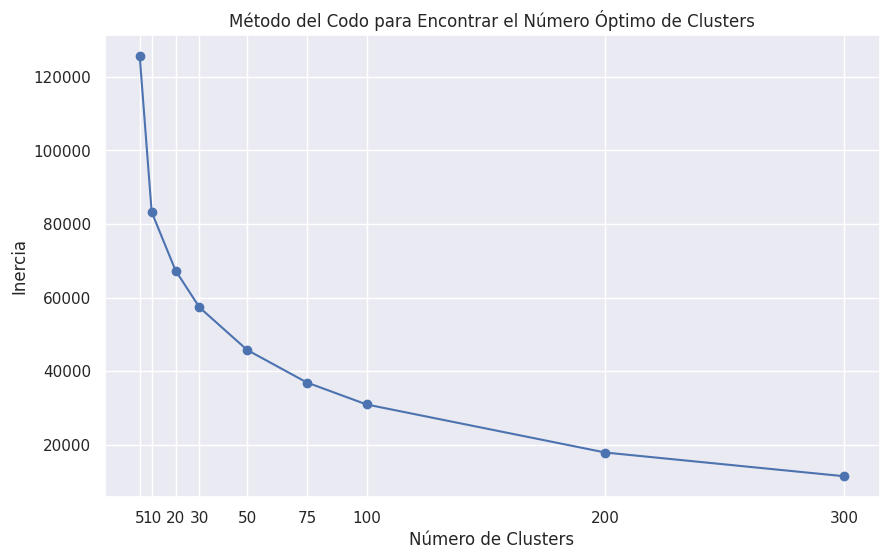

In [ ]:
inertia = []
list_clusters = [5, 10, 20, 30, 50, 75, 100, 200, 300]

for n_clusters in list_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(df_procesado)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(list_clusters, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para Encontrar el Número Óptimo de Clusters')
plt.xticks(list_clusters)
plt.grid(True)
plt.show()

Al observar el gráfico resultante, se pueden obtener conclusiones sobre el número apropiado de clusters. La regla del codo sugiere elegir el número de clusters donde la reducción en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gráfico donde la curva de inercia comienza a aplanarse o forma un codo.

## Reducción de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos clásico disponible en la librería **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene información de **178 muestras de vino** provenientes de la región italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que actúan como etiquetas para el análisis supervisado, pero aquí se usarán solo como referencia en la visualización.

Cada muestra está descrita por **13 variables químicas** obtenidas de un análisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentración de ácido málico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentración total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relación de absorbancia que mide la calidad del vino.
* **Proline**: concentración de prolina (un aminoácido).

Estas características permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del análisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparación entre ambas técnicas permitirá observar cómo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducción de dimensionalidad en datos con mayor número de variables que en el caso del dataset *Wine*.



In [ ]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [ ]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0




### 1. **Análisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gráfico de varianza acumulada, identificando cuántos componentes son necesarios para capturar al menos el **90–95% de la información**.
* Construir tablas y gráficos que muestren cómo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qué características químicas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



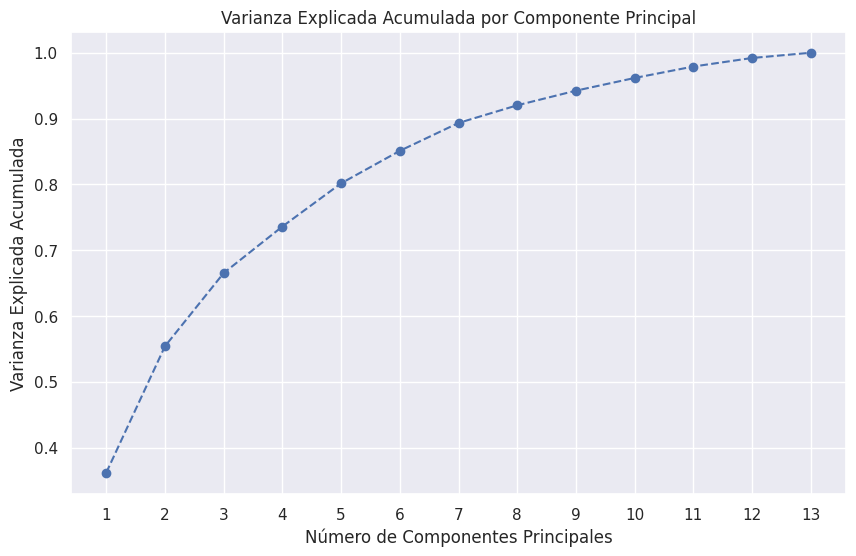

Número de componentes para capturar al menos 90% de la varianza: 8
Número de componentes para capturar al menos 95% de la varianza: 10


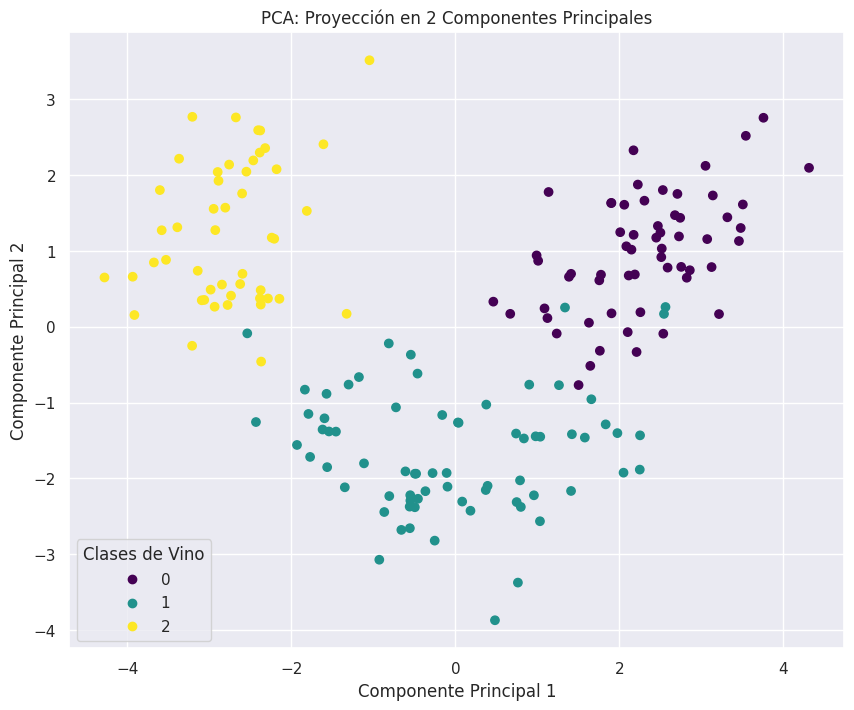

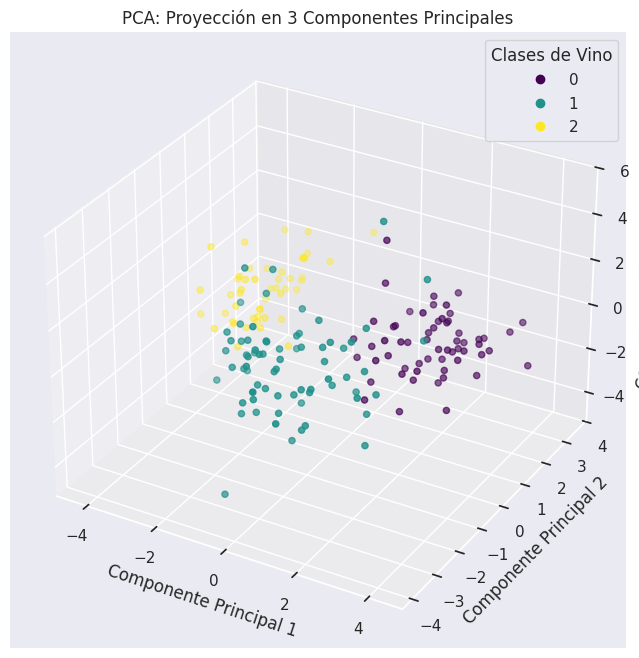


Loadings (coeficientes de las variables en los componentes principales):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
alcohol,0.144329,0.483652,-0.207383,-0.017856,-0.265664,0.213539,-0.056396,0.396139,-0.508619,0.211605,-0.225917,-0.266286,0.014970
malic_acid,-0.245188,0.224931,0.089013,0.536890,0.035214,0.536814,0.420524,0.065827,0.075283,-0.309080,0.076486,0.121696,0.025964
ash,-0.002051,0.316069,0.626224,-0.214176,-0.143025,0.154475,-0.149171,-0.170260,0.307694,-0.027125,-0.498691,-0.049622,-0.141218
alcalinity_of_ash,-0.239320,-0.010591,0.612080,0.060859,0.066103,-0.100825,-0.286969,0.427970,-0.200449,0.052799,0.479314,-0.055743,0.091683
magnesium,0.141992,0.299634,0.130757,-0.351797,0.727049,0.038144,0.322883,-0.156361,-0.271403,0.067870,0.071289,0.062220,0.056774
total_phenols,0.394661,0.065040,0.146179,0.198068,-0.149318,-0.084122,-0.027925,-0.405934,-0.286035,-0.320131,0.304341,-0.303882,-0.463908
flavanoids,0.422934,-0.003360,0.150682,0.152295,-0.109026,-0.018920,-0.060685,-0.187245,-0.049578,-0.163151,-0.025694,-0.042899,0.832257
nonflavanoid_phenols,-0.298533,0.028779,0.170368,-0.203301,-0.500703,-0.258594,0.595447,-0.233285,-0.195501,0.215535,0.116896,0.042352,0.114040
proanthocyanins,0.313429,0.039302,0.149454,0.399057,0.136860,-0.533795,0.372139,0.368227,0.209145,0.134184,-0.237363,-0.095553,-0.116917
color_intensity,-0.088617,0.529996,-0.137306,0.065926,-0.076437,-0.418644,-0.227712,-0.033797,-0.056218,-0.290775,0.031839,0.604222,-0.011993


In [ ]:
from sklearn.preprocessing import StandardScaler
# Separate features and target
X = wine.drop(target, axis=1)
y = wine[target]

# Standardize the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Varianza Explicada Acumulada por Componente Principal')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)
plt.show()

# Identify number of components for 90-95% variance
n_components_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1

print(f"Número de componentes para capturar al menos 90% de la varianza: {n_components_90}")
print(f"Número de componentes para capturar al menos 95% de la varianza: {n_components_95}")


# Projections onto first few components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Create DataFrames for visualizations
df_pca_2d = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
df_pca_2d['wine_class'] = y

df_pca_3d = pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
df_pca_3d['wine_class'] = y

# Visualize 2D PCA
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_pca_2d['PC1'], df_pca_2d['PC2'], c=df_pca_2d['wine_class'], cmap='viridis')
plt.title('PCA: Proyección en 2 Componentes Principales')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
legend = plt.legend(*scatter.legend_elements(), title="Clases de Vino")
plt.grid(True)
plt.show()

# Visualize 3D PCA
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pca_3d['PC1'], df_pca_3d['PC2'], df_pca_3d['PC3'], c=df_pca_3d['wine_class'], cmap='viridis')
ax.set_title('PCA: Proyección en 3 Componentes Principales')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
legend = ax.legend(*scatter.legend_elements(), title="Clases de Vino")
plt.show()


# Analyze loadings (Coefficients of each variable in the components)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=features)

print("\nLoadings (coeficientes de las variables en los componentes principales):")
display(loadings)



### 2. **Análisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperparámetros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir cómo los hiperparámetros afectan la estructura de los clústeres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



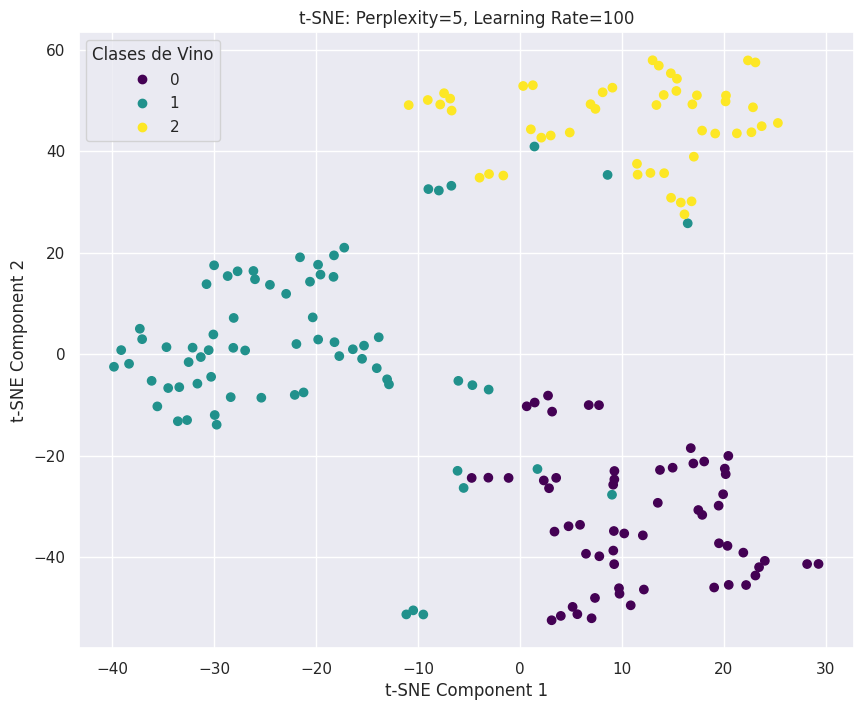

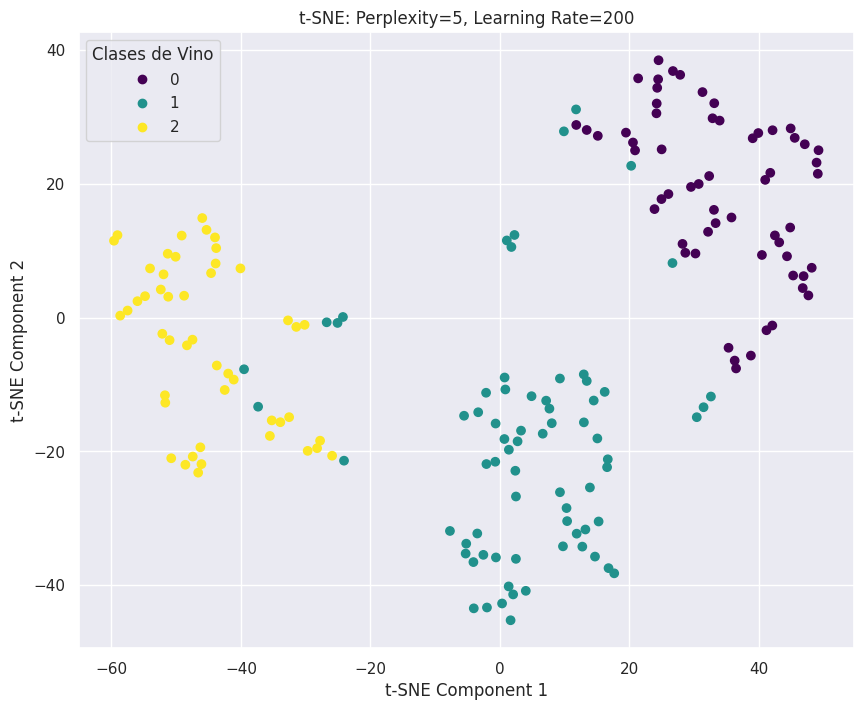

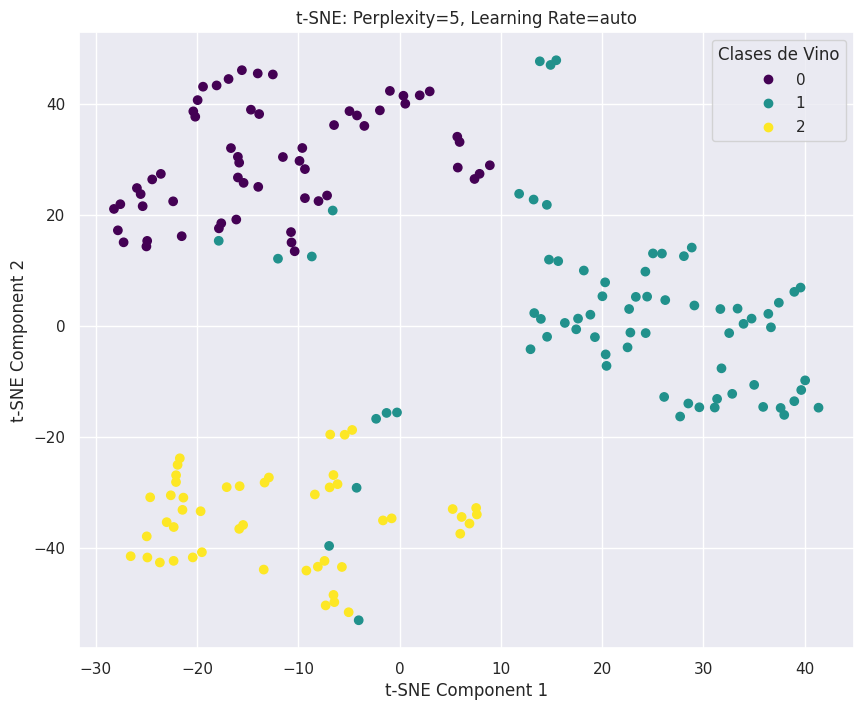

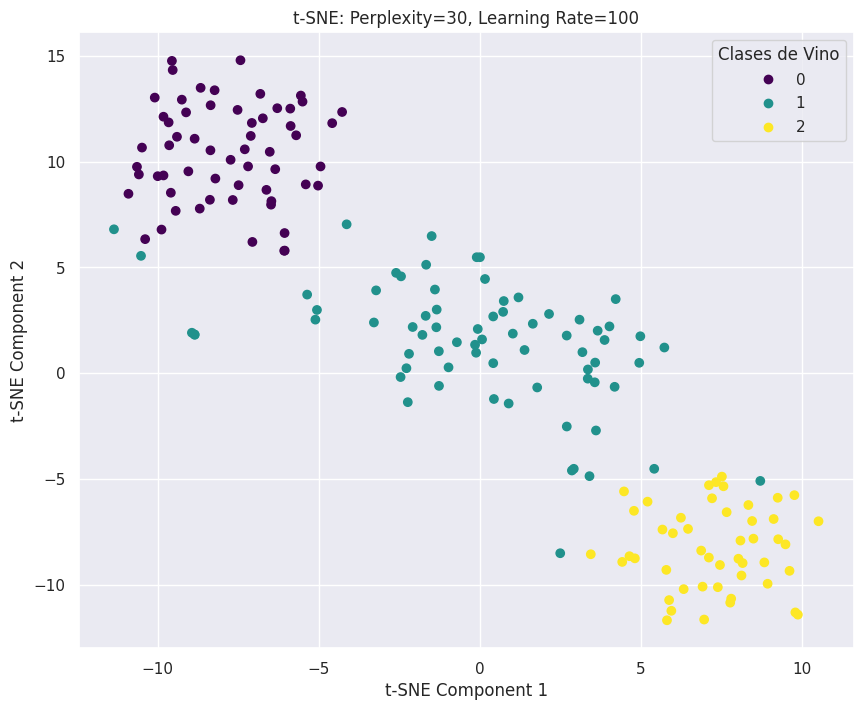

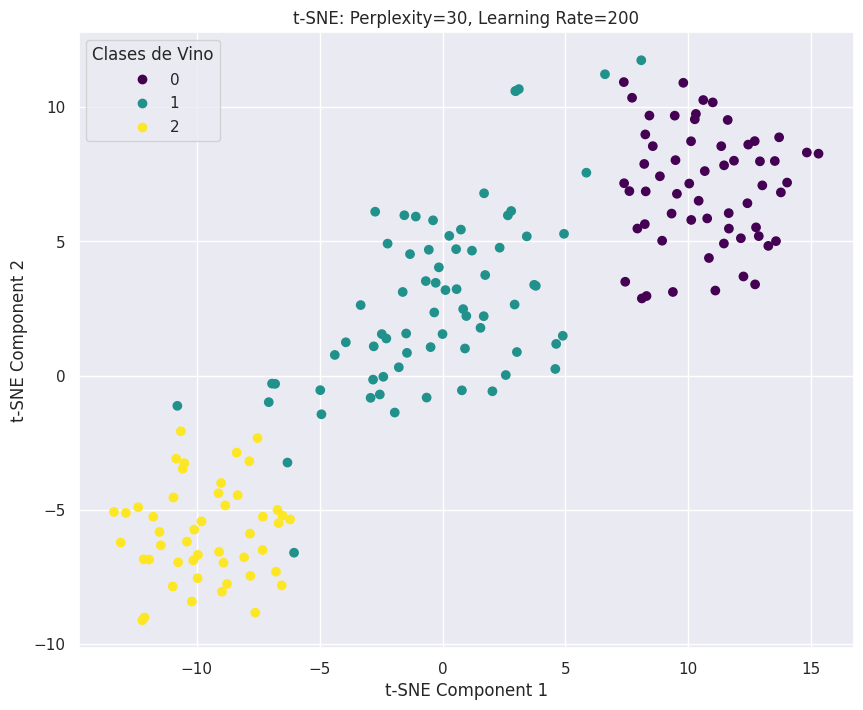

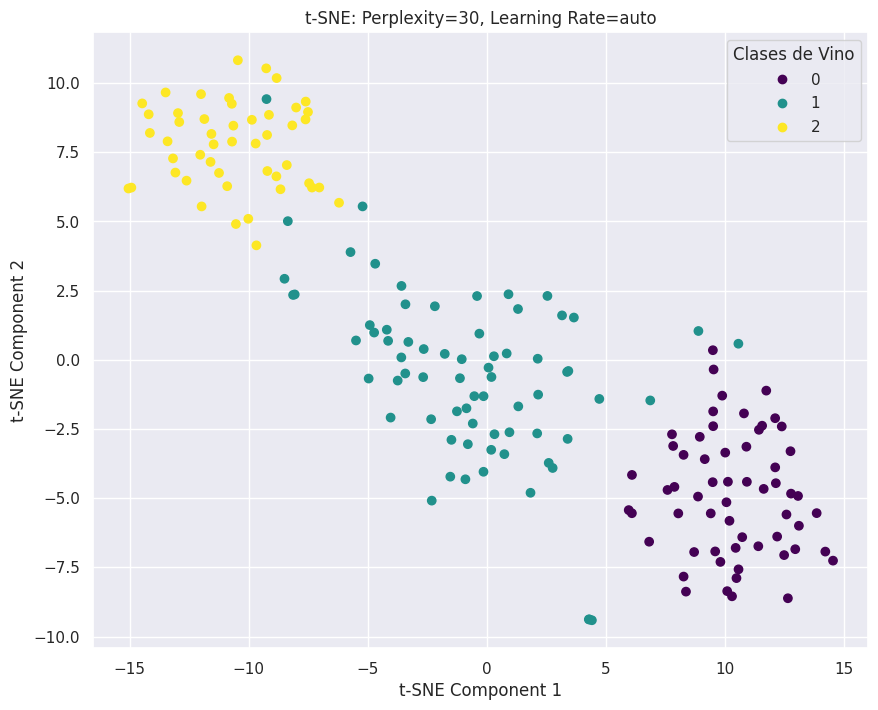

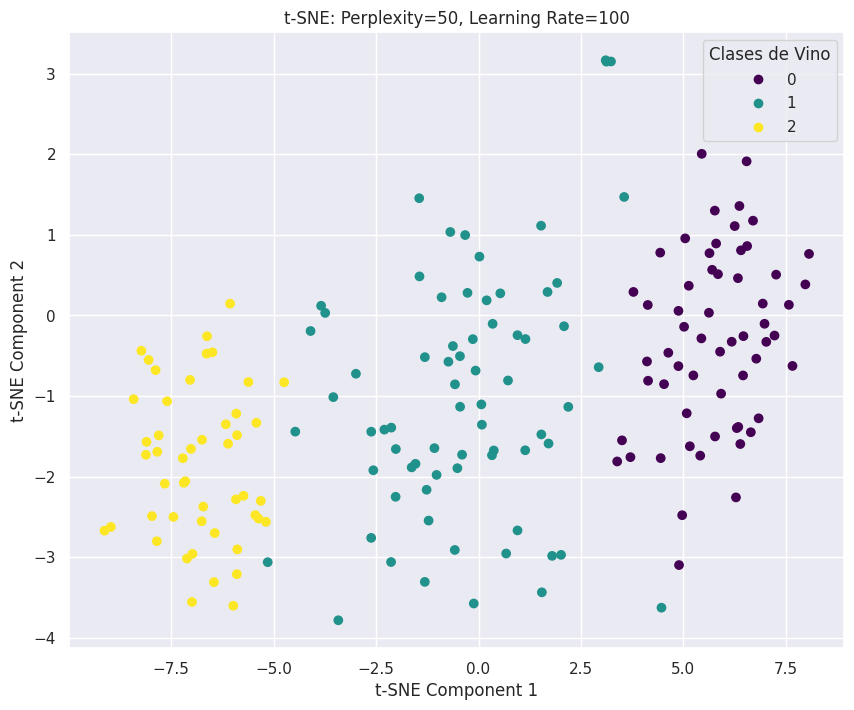

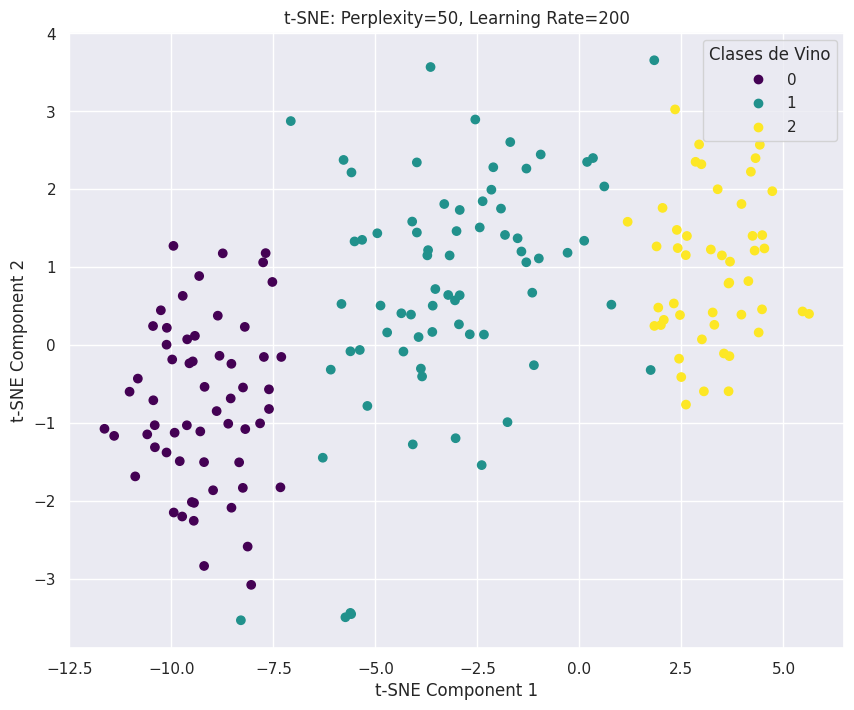

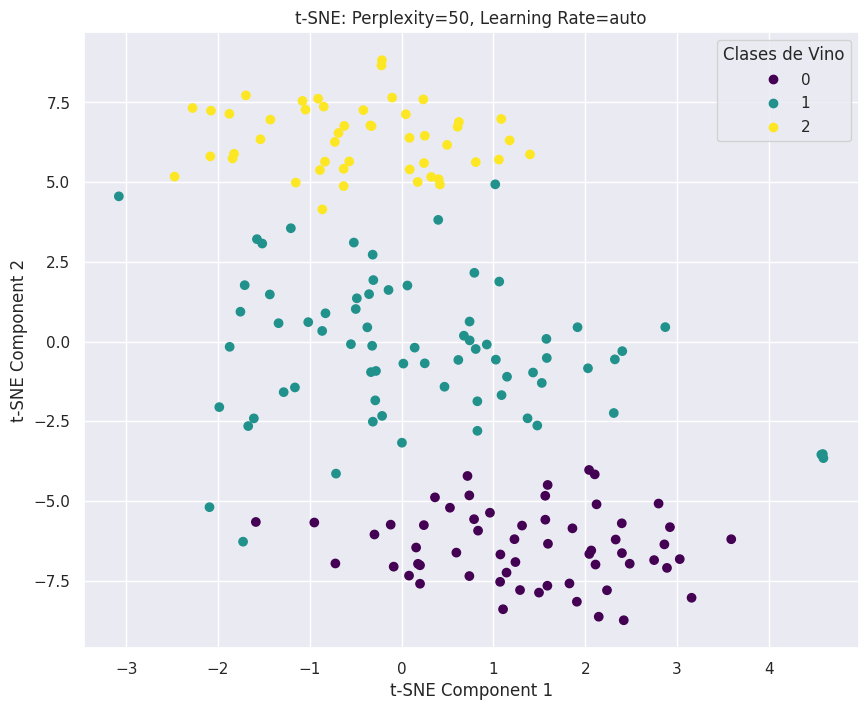

In [ ]:
# Apply t-SNE with different hyperparameters
perplexities = [5, 30, 50]
learning_rates = [100, 200, 'auto']

for perplexity in perplexities:
    for learning_rate in learning_rates:
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, learning_rate=learning_rate, init='pca')
            X_tsne = tsne.fit_transform(X_scaled)

            df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
            df_tsne['wine_class'] = y

            plt.figure(figsize=(10, 8))
            scatter = plt.scatter(df_tsne['TSNE1'], df_tsne['TSNE2'], c=df_tsne['wine_class'], cmap='viridis')
            plt.title(f't-SNE: Perplexity={perplexity}, Learning Rate={learning_rate}')
            plt.xlabel('t-SNE Component 1')
            plt.ylabel('t-SNE Component 2')
            legend = plt.legend(*scatter.legend_elements(), title="Clases de Vino")
            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"Could not run t-SNE for perplexity={perplexity}, learning_rate={learning_rate}: {e}")



### 3. **Comparación entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada técnica:

  * PCA como método **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como método **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qué escenarios prácticos sería más recomendable usar PCA (interpretabilidad, reducción previa para modelos) o t-SNE (exploración y visualización de clústeres).
* Reflexionar sobre la **importancia de la reducción de dimensionalidad** en datasets de alta dimensión como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje automático.
  * Facilitar la interpretación y comunicación de resultados.



In [ ]:
# FIXME

### 3. Comparación entre PCA y t-SNE

Basándonos en las visualizaciones obtenidas de PCA y t-SNE, podemos contrastar ambas técnicas:

**PCA (Análisis de Componentes Principales):**

*   **Naturaleza:** Es un método de reducción de dimensionalidad **lineal**. Busca las direcciones (componentes principales) en el espacio de alta dimensión que explican la mayor cantidad de varianza en los datos.
*   **Interpretación:** Los componentes principales son combinaciones lineales de las variables originales. Los "loadings" (coeficientes) indican la contribución de cada variable original a cada componente principal, lo que permite interpretar qué características influyen más en las nuevas dimensiones. Es útil para entender las relaciones **globales** y la estructura general de la varianza en los datos.
*   **Ventajas:** Es computacionalmente eficiente, las componentes son ortogonales, y es interpretable en términos de varianza explicada.
*   **Limitaciones:** Puede no ser efectivo para capturar estructuras **no lineales** o relaciones complejas entre puntos si estos no son linealmente separables.

**t-SNE (t-distributed Stochastic Neighbor Embedding):**

*   **Naturaleza:** Es un método de reducción de dimensionalidad **no lineal**. Se enfoca en preservar las **distancias locales** entre los puntos en el espacio de alta dimensión al proyectarlos a un espacio de menor dimensión. Es decir, si dos puntos están cerca en el espacio original, t-SNE intenta mantenerlos cerca en el espacio reducido.
*   **Interpretación:** La interpretación de los ejes de un gráfico de t-SNE es difícil ya que no representan combinaciones lineales directas de las variables originales ni están ordenados por varianza. La visualización se centra en la formación de **agrupaciones** o clústeres.
*   **Ventajas:** Es excelente para visualizar la estructura de clústeres y relaciones **no lineales** en conjuntos de datos complejos. A menudo produce visualizaciones donde las clases o grupos se separan de manera más clara que con PCA.
*   **Limitaciones:** Es computacionalmente más costoso que PCA. Los resultados pueden ser sensibles a la elección de hiperparámetros como la "perplexity" y el "learning rate". No preserva bien las distancias **globales**; solo las distancias relativas entre vecinos cercanos son significativas.

**Escenarios de Aplicación:**

*   **PCA es más recomendable cuando:** Se necesita reducir la dimensionalidad como paso previo a otros algoritmos de aprendizaje automático (especialmente métodos lineales), cuando la interpretabilidad de las componentes es importante, o para tareas donde la varianza global es relevante. También es preferible para datasets muy grandes debido a su eficiencia.
*   **t-SNE es más recomendable cuando:** El objetivo principal es la **visualización** para identificar clústeres, explorar la estructura de los datos, o cuando se sospecha que existen relaciones no lineales complejas.

**Importancia de la Reducción de Dimensionalidad (en datasets como Wine):**

En datasets de alta dimensión como el Wine (13 variables), la reducción de dimensionalidad es crucial por varias razones:

1.  **Visualización de Patrones:** Permite proyectar los datos a 2D o 3D para su visualización, revelando patrones, agrupaciones o estructuras que serían invisibles en el espacio original de alta dimensión. En el caso del Wine dataset, tanto PCA como t-SNE ayudaron a visualizar la separación (aunque con diferente énfasis) de las tres clases de vinos.
2.  **Reducción de Complejidad y Ruido:** Disminuir el número de variables puede ayudar a eliminar ruido irrelevante o redundancia, lo que a menudo mejora el rendimiento y la eficiencia de los algoritmos de aprendizaje automático aplicados posteriormente.
3.  **Facilitar la Interpretación y Comunicación:** Una representación en baja dimensión es mucho más fácil de entender e interpretar, facilitando la comunicación de los hallazgos a otras personas.

En resumen, ambas técnicas son valiosas, pero su utilidad depende del objetivo del análisis. PCA se enfoca en la varianza y relaciones globales, mientras que t-SNE se enfoca en preservar las distancias locales y visualizar clústeres. Para el Wine dataset, t-SNE parece ofrecer una separación visual más clara de las clases, sugiriendo que las relaciones locales o no lineales son importantes para distinguir las variedades de vino.